<a href="https://colab.research.google.com/github/mmaruthi/ML-BootCamp-/blob/master/Day2(Final_Code_Crude_Oil_Prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crude Oil Prediction

Importing the required libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
import pickle

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Reading the Dataset into pandas DataFrame

In [0]:
file_path = 'C:\\Users\\gudkumar\Desktop\\Capstone_main\\crude_trade_daily.csv'

In [0]:
trade_crude  = pd.read_csv(file_path)
trade_crude.index = pd.to_datetime(trade_crude.Date)

In [0]:
trade_crude.drop(['Date', 'Change %'], axis= 1, inplace=True)

In [0]:
trade_crude = trade_crude.sort_index()

In [0]:
trade_crude.head()

,Price,Open,High,Low,Vol.
Date,,,,,
2001-01-02,27.21,26.90,27.40,26.65,52.32K
2001-01-03,28.00,27.21,28.14,27.08,66.63K
2001-01-04,28.14,27.99,28.72,27.67,74.38K
2001-01-05,27.95,28.14,28.78,27.86,63.85K
2001-01-08,27.32,28.12,28.38,27.20,76.06K


Taking only the Price Column from the above DataFrame

In [0]:
oil = trade_crude[['Price']]

Setting the frequency to business day's only

In [0]:
oil = oil.asfreq('B')

In [0]:
oil.head()

,Price
Date,
2001-01-02,27.21
2001-01-03,28.00
2001-01-04,28.14
2001-01-05,27.95
2001-01-08,27.32


Filling the Missing Values

In [0]:
oil.ffill(axis=0,inplace=True)

In [0]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4864 entries, 2001-01-02 to 2019-08-23
Freq: B
Data columns (total 1 columns):
Price    4864 non-null float64
dtypes: float64(1)
memory usage: 76.0 KB


Plotting the time series data

Text(0.5, 1.0, 'Crude Oil Price')

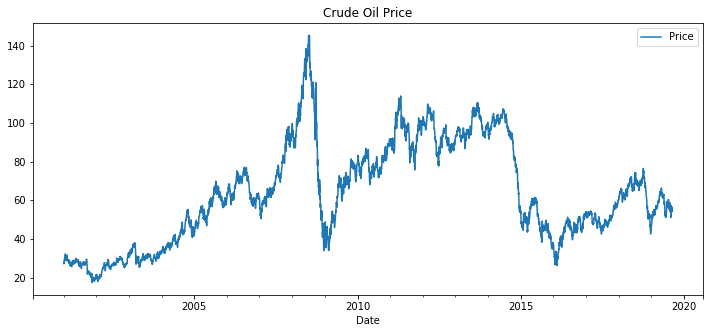

In [0]:
oil.plot(figsize=(12,5))
plt.title('Crude Oil Price')

Decomposing the time series in its components

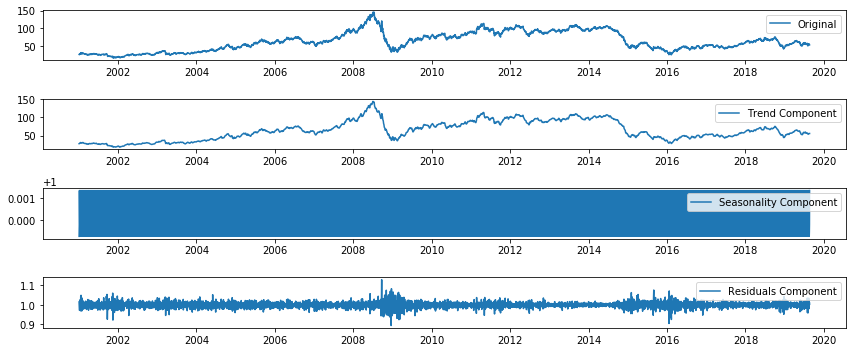

In [0]:
from plotly.plotly import plot_mpl
#oil1 = oil1.asfreq('B')
#oil1.index.freq = 'B'
decomposition = seasonal_decompose(oil['Price'], model='mul')

#fig = components.plot()
#plot_mpl(fig)
plt.figure(figsize=(12,5))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(oil['Price'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend Component')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality Component')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals Component')
plt.legend(loc='best')
plt.tight_layout()

The above plot shows that the seasonality is not very prominent, so after resampling on monthly basis

In [0]:
oil_one= oil.resample(rule='M').mean()

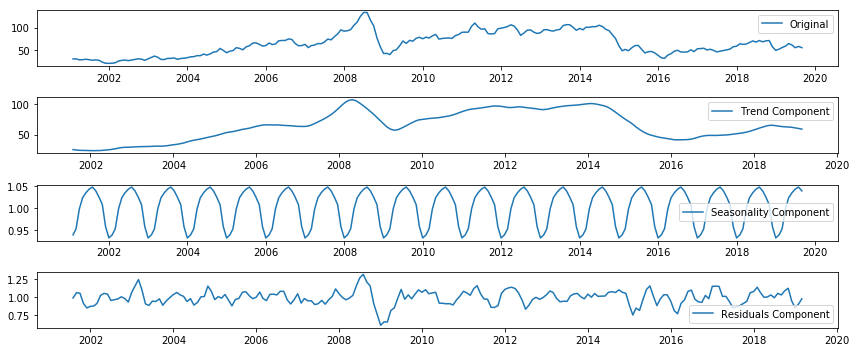

In [0]:
decomposition1 = seasonal_decompose(oil_one['Price'], model='mul')

#fig = components.plot()
#plot_mpl(fig)
plt.figure(figsize=(12,5))

trend1 = decomposition1.trend
seasonal1 = decomposition1.seasonal
residual1 = decomposition1.resid

plt.subplot(411)
plt.plot(oil_one['Price'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend1, label='Trend Component')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal1,label='Seasonality Component')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual1, label='Residuals Component')
plt.legend(loc='best')
plt.tight_layout()

From the above plot we can see that the seasonalit is looking quite prominent as compared to the previous plot

In [0]:
seasonal2 = seasonal1['2001-01-01':'2002-01-01']

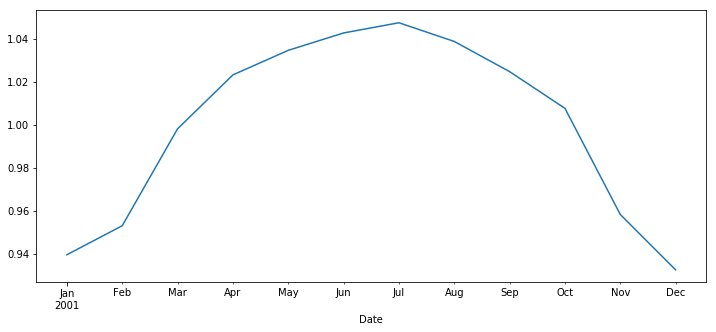

In [0]:
seasonal2.plot(figsize=(12,5))

From the above plot we can see that
1. The prices increase during july-august this is due to summer driving seasons
2. The prices start decreasing at start of october

Also from above plots we can see that there is no clear seasonality or trend in the data, so lets use exponential forecast models

# Holt-Winters Method for Forecasting

In [0]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [0]:
oil_hws = oil
oil_hws.head()

,Price
Date,
2001-01-02,27.21
2001-01-03,28.00
2001-01-04,28.14
2001-01-05,27.95
2001-01-08,27.32


Splitting the data in train and test for holt-winters exponential smoothing 

In [0]:
train_hws = oil_hws.iloc[0:4834]
test_hws = oil_hws.iloc[4834:]

Creating DataFrame for storing results from holt-winters method

In [0]:
hws_model_results = test_hws

First Tryin the simple exponential soothing

Function for generating the simple-exponential smoothing results

In [0]:
def simple_expo(span, time_series):
    alpha = 2/(span + 1)
    return SimpleExpSmoothing(time_series).fit(smoothing_level=alpha,optimized=False)

Using 5 day and 25 days exponential smoothing

In [0]:
model_s5day_exp = simple_expo(5, train_hws['Price'])

In [0]:
hws_model_results['SES5'] = model_s5day_exp.forecast(30)

In [0]:
model_s25day_exp = simple_expo(25, train_hws['Price'])

In [0]:
hws_model_results['SES25'] = model_s25day_exp.forecast(30)

Using Double exponential smoothing as it also incorporates the trend component

In [0]:
model_des_mul = ExponentialSmoothing(train_hws['Price'], trend='mul').fit()

In [0]:
hws_model_results['DESMul'] = model_des_mul.forecast(30)

In [0]:
model_des_add = ExponentialSmoothing(train_hws['Price'], trend='add').fit()
hws_model_results['DESadd'] = model_des_mul.forecast(30)

Now Using triple exponential smoothing which takes into account both trend and seasonality

In [0]:
model_tes_add = ExponentialSmoothing(train_hws['Price'],trend='add',seasonal='add',seasonal_periods=313).fit()

In [0]:
hws_model_results['TESadd'] = model_tes_add.forecast(30)

In [0]:
model_tes_mul = ExponentialSmoothing(train_hws['Price'],trend='mul',seasonal='mul',seasonal_periods=313).fit()
hws_model_results['TESmul'] = model_tes_add.forecast(30)

Checking the result dataframe head

In [0]:
hws_model_results.head()

,Price,SES5,SES25,DESMul,DESadd,TESadd,TESmul
Date,,,,,,,
2019-07-15,59.58,59.468897,57.725343,60.213209,60.213209,60.088029,60.088029
2019-07-16,57.62,59.468897,57.725343,60.216526,60.216526,59.488715,59.488715
2019-07-17,56.78,59.468897,57.725343,60.219842,60.219842,59.233981,59.233981
2019-07-18,55.30,59.468897,57.725343,60.223159,60.223159,59.686775,59.686775
2019-07-19,55.63,59.468897,57.725343,60.226476,60.226476,59.821270,59.821270


Plotting the forecast Result

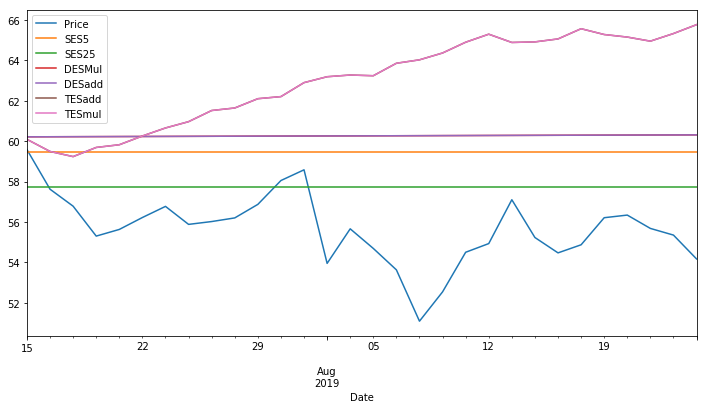

In [0]:
hws_model_results.plot(figsize=(12,6)).autoscale(axis='x',tight=True);

1. From the above we can see that the multiplicative and additive assumptions for trend and seasonality is giving the same result
2. single exponential smoothing is performing better than Doulble and triple exponential smoothing

Function to calculate Mean Square error and root mean square error

In [0]:
def eval_matrix(actual, forecast):
    mean_error = mean_squared_error(actual, forecast)
    root_mean_error = np.sqrt(mean_error)
    return [mean_error, root_mean_error]

In [0]:
simple_exp5_result  = eval_matrix(hws_model_results['Price'], hws_model_results['SES5'])
simple_exp25_result = eval_matrix(hws_model_results['Price'], hws_model_results['SES25'])
double_exp_result   = eval_matrix(hws_model_results['Price'], hws_model_results['DESMul'])
triple_exp_result   = eval_matrix(hws_model_results['Price'], hws_model_results['TESmul'])

In [0]:
holt_winter_matrix = pd.DataFrame({'SES5':simple_exp5_result, 'SES25':simple_exp25_result, 'DES':double_exp_result,
                                  'TES':triple_exp_result})

In [0]:
holt_winter_matrix.index = ['MSE', 'RMSE']

In [0]:
holt_winter_matrix

,SES5,SES25,DES,TES
MSE,17.352258,7.122984,24.054146,64.337729
RMSE,4.165604,2.668892,4.904503,8.021080


# Applying Regressive model for Prediction

We can see that ADF suggests that the TS is non-stationary, now ARIMA works on stationary TS and Accepts three parameters

1. p ---> The order of AR term
2. q ---> The order of MA term
3. d ---> The number of differencing required to make the TS stationary

In [0]:
oil_arima = oil

Test and train for ARIMA model

In [0]:
train_arima = oil_arima.iloc[0:4834]
test_arima = oil_arima.iloc[4834:]

# Checking Stationarity

The above plot shows that the data is non-stationary, we will use two methods to check if the TS is stationary or non-stationary
1. Rolling Statistics
2. Agumented Dickey-Fuller(ADF Test)

In [0]:
def stationarity_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    #determining and plotting Rolling statistcis
    rolmean = series.rolling(window=7).mean()
    rolstd = series.rolling(window=7).std()
    
    plt.figure(figsize=(12,5))
    orig = plt.plot(series, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

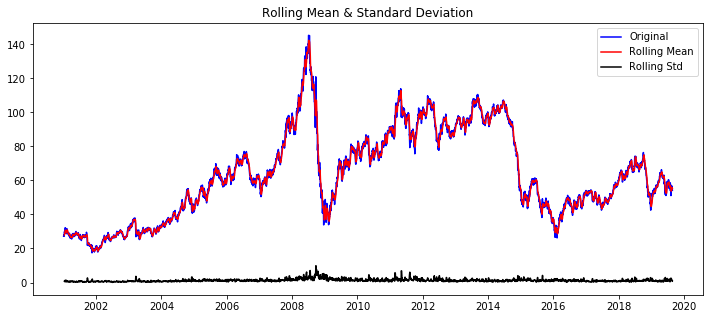

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.016508
p-value                    0.279382
# lags used                5.000000
# observations          4858.000000
critical value (1%)       -3.431697
critical value (5%)       -2.862135
critical value (10%)      -2.567087
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [0]:
stationarity_test(oil_arima['Price'])

Diffrencing the time series one time and then check if the time series gets stationary or not

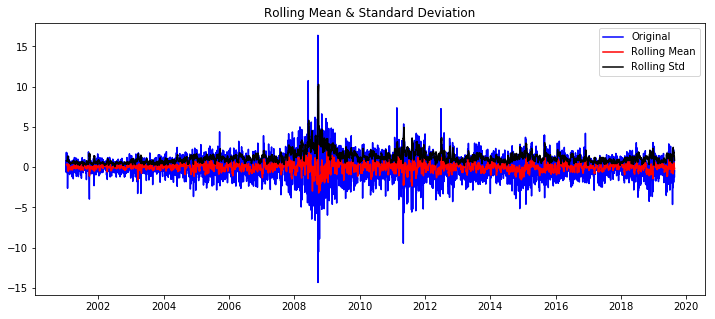

Augmented Dickey-Fuller Test: 
ADF test statistic       -31.771910
p-value                    0.000000
# lags used                4.000000
# observations          4858.000000
critical value (1%)       -3.431697
critical value (5%)       -2.862135
critical value (10%)      -2.567087
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [0]:
stationarity_test(oil_arima['Price'].diff().dropna())

The above plot suggests that the d = 1 will work on this dataset, lets check the distribution for the time series after the diffrencing.

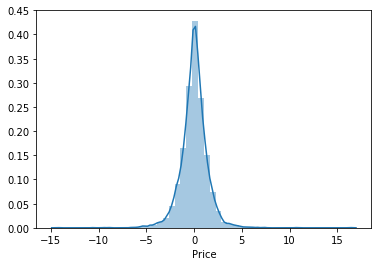

In [0]:
sns.distplot(oil_arima['Price'].diff().dropna())

From the above plot we can see that the differencing of order one makes the time series stationary and also has normal distribution

Lets plot PACF to find the order of AR for ARIMA model

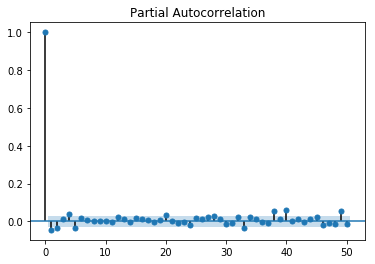

In [0]:
plot_pacf(oil_arima['Price'].diff().dropna(), lags=50);

If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., 
if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. 
The lag at which the PACF cuts off is the indicated number of AR terms.
According to this the AR terms to be used should be 1.

Lets check the acf plot to determine the MA terms for the ARIMA model

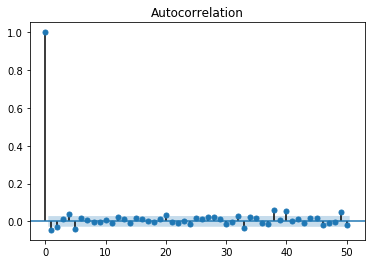

In [0]:
plot_acf(oil_arima['Price'].diff().dropna(), lags=50);

If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., 
if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. 
The lag at which the ACF cuts off is the indicated number of MA terms.
This suggets the MA terms of order 1

Now we will try ARIMA model with order =(1,1,1)

In [0]:
model_arima = ARIMA(train_arima['Price'], order = (1,1,1))

In [0]:
start_arima=len(train_arima)
end_arima=len(train_arima)+len(test_arima)-1

Fitting the model

In [0]:
results_arima = model_arima.fit()

Model Summary

In [0]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 4833
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8490.666
Method:                       css-mle   S.D. of innovations              1.402
Date:                Mon, 30 Sep 2019   AIC                          16989.331
Time:                        11:17:18   BIC                          17015.264
Sample:                    01-03-2001   HQIC                         16998.436
                         - 07-12-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0068      0.019      0.361      0.718      -0.030       0.044
ar.L1.D.Price     0.2516      0.176      1.428      0.153      -0.094       0.597
ma.L1.D.Price    -0.3003      0.173     -1.733      0.083      -0.640       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.9751           +0.0000j            3.9751            0.0000
MA.1            3.3300           +0.0000j            3.3300            0.0000
-----------------------------------------------------------------------------
"""

Prediction on future time stamps

In [0]:
predictions_arima = results_arima.predict(start=start_arima, end=end_arima, typ='levels')

Plotting the predictions and test data

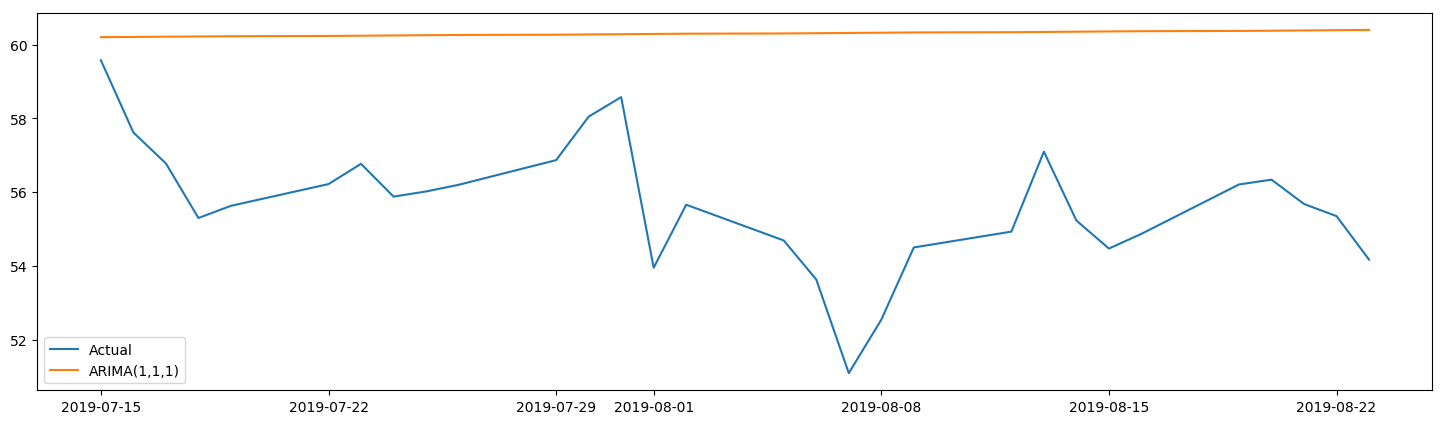

In [0]:
plt.figure(figsize=(18,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test_arima, label='Actual')
plt.plot(predictions_arima, label='ARIMA(1,1,1)')
plt.legend(loc='bottom left', fontsize=10)

Calculating the evaluation matrix for the arima model

In [0]:
matrix_arima = eval_matrix(test_arima, predictions_arima)

In [0]:
matrix_arima

[24.499493900157894, 4.949696344237482]

Let's plot the residual to ensure that there are no patterns[i.e it is having contant mean and variance]

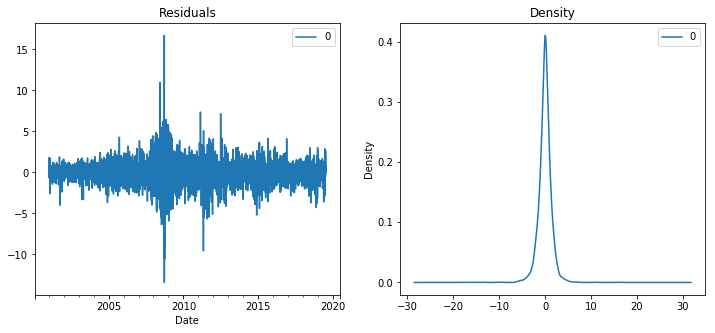

In [0]:
residuals = pd.DataFrame(results_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(12,5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

From the above plot we residual error seems to be fine with near zero mean and uniform variance

Lets try Auto ARIMA to figure out the best values of p,d,q

In [0]:
model_auto = auto_arima(oil_arima['Price'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Fit ARIMA: order=(1, 1, 1); AIC=17096.387, BIC=17122.344, Fit time=1.659 seconds
Fit ARIMA: order=(0, 1, 0); AIC=17104.842, BIC=17117.821, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0); AIC=17096.966, BIC=17116.435, Fit time=0.118 seconds
Fit ARIMA: order=(0, 1, 1); AIC=17096.316, BIC=17115.784, Fit time=0.131 seconds
Fit ARIMA: order=(0, 1, 2); AIC=17094.460, BIC=17120.418, Fit time=0.191 seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 3); AIC=17095.317, BIC=17127.764, Fit time=0.284 seconds
Total fit time: 4.739 seconds


In [0]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 4863
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -8543.230
Method:                       css-mle   S.D. of innovations              1.402
Date:                Mon, 23 Sep 2019   AIC                          17094.460
Time:                        17:28:06   BIC                          17120.418
Sample:                             1   HQIC                         17103.571
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.019      0.298      0.766      -0.031       0.042
ma.L1.D.y     -0.0457      0.014     -3.186      0.001      -0.074      -0.018
ma.L2.D.y     -0.0273      0.014     -1.966      0.049      -0.055   -8.32e-05
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            5.2736           +0.0000j            5.2736            0.0000
MA.2           -6.9472           +0.0000j            6.9472            0.5000
-----------------------------------------------------------------------------
"""

Let's plot te daignostic for the above model

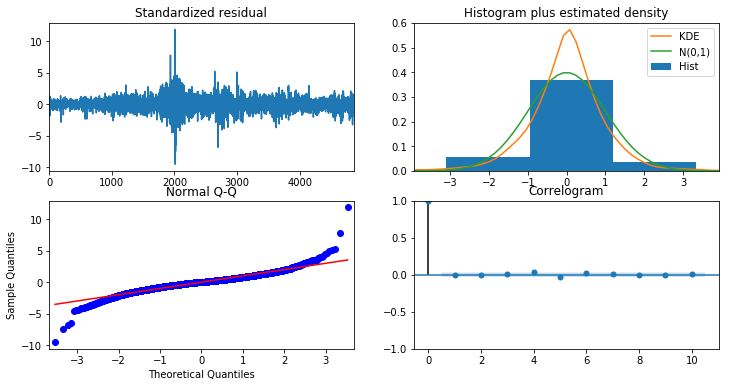

In [0]:
model_auto.plot_diagnostics(figsize=(12,6))
plt.show()

1. Standardized Residual          ---> Seems to flactuate around zero mean and has uniform variance
2. HistogramPlusEstimated Density ---> Suggets normal distribution with mean zero
3. NormalQ-Q                      ---> Almost all the dots are in line with red line any deviation would mean that the distribution is skewed.
4. Correlogram                    ---> Seems that the residuals are not auto-correletated.

In [0]:
model_two = ARIMA(train_arima['Price'], order = (0,1,2))

In [0]:
results_two = model_two.fit()

In [0]:
predictions_two = results_two.predict(start=start_arima, end=end_arima, typ='levels')

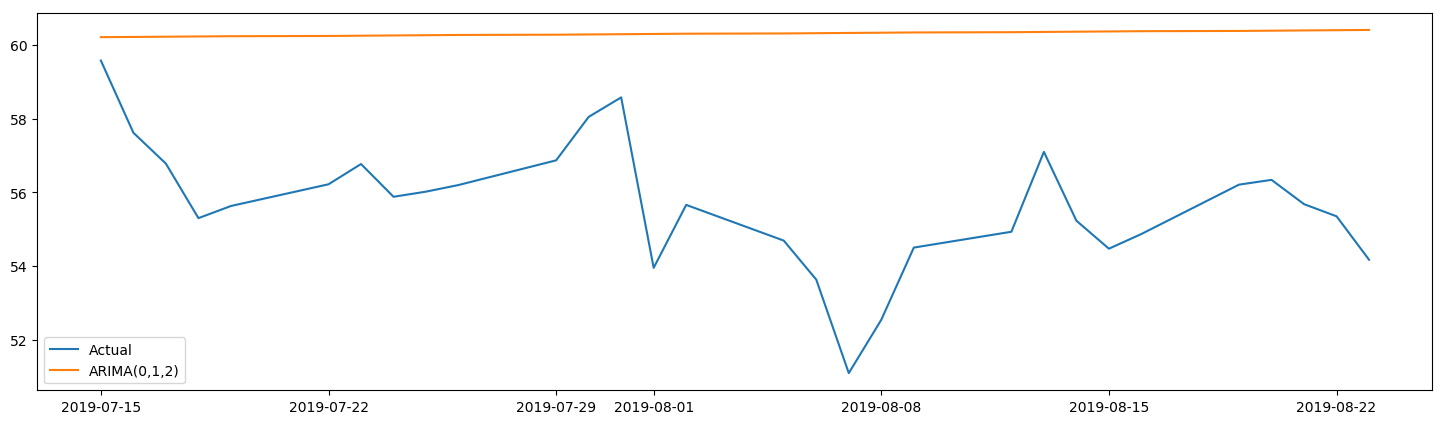

In [0]:
plt.figure(figsize=(18,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test_arima, label='Actual')
plt.plot(predictions_two, label='ARIMA(0,1,2)')
plt.legend(loc='bottom left', fontsize=10)

In [0]:
model_two_matrix = eval_matrix(test_arima, predictions_two)

In [0]:
model_two_matrix

[24.586155205557926, 4.958442820640158]

# LSTM Model For Prediction

In [0]:
oil_lstm = oil

In [0]:
#train_lstm = oil_lstm.iloc[0:4834]
#test_lstm = oil_lstm.iloc[4834:]

In [0]:
new_data = pd.DataFrame(index=oil_lstm.index,columns=['Price'])

In [0]:
for i in range(0,len(oil_lstm)):
    new_data['Price'][i] = oil_lstm['Price'][i]

In [0]:
new_data.head()

,Price
Date,
2001-01-02,27.21
2001-01-03,28
2001-01-04,28.14
2001-01-05,27.95
2001-01-08,27.32


Creating test_train split

In [0]:
dataset = new_data.values

train_lstm = dataset[0:4834,:]
test_lstm = dataset[4834:,:]

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [0]:
x_train, y_train = [], []
for i in range(5,len(train_lstm)):
    x_train.append(scaled_data[i-5:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [0]:
x_train.shape

(4829, 5)

In [0]:
y_train.shape

(4829,)

create the data structure in which the LSTM creates the input

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Create and fit the LSTM network

In [0]:
model = Sequential()
model.add(LSTM(units=5, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=5))
model.add(Dense(1))

W0930 11:50:44.543123 17140 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0930 11:50:44.605375 17140 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 11:50:44.612132 17140 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Compiling the model

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')

W0930 11:50:48.898172 17140 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.fit(x_train, y_train, epochs=40, batch_size=5, verbose=0)

W0930 11:50:54.105728 17140 deprecation.py:323] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0930 11:50:56.306059 17140 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0930 11:50:56.474484 17140 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



LSTM Model Summary

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 5)              140       
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________


In [0]:
inputs = new_data[len(new_data) - len(test_lstm) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs) # Using the Min_Max Scaler

In [0]:
X_test = []
for i in range(5,inputs.shape[0]):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) # 3 Dimensional Shape which is required by the LSTM model
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [0]:
results_lstm = oil_lstm.iloc[4834:]

In [0]:
results_lstm['LSTMPredictions'] = closing_price

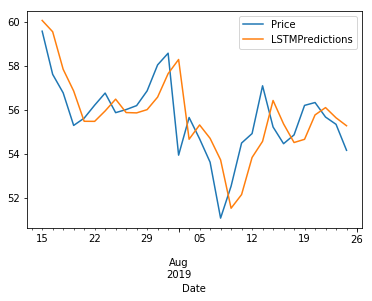

In [0]:
results_lstm.plot()

In [0]:
lstm_eval = eval_matrix(results_lstm['Price'], results_lstm['LSTMPredictions'])

In [0]:
lstm_eval 

[2.1256176970415654, 1.4579498266543898]

# Saving the Model

Saving LSTM model to disk

In [0]:
pickle.dump(model, open('lstm_model.pkl','wb'))

Saving the Scaler

In [0]:
pickle.dump(scaler, open('scaler_MM.pkl','wb'))

# Final Martix For all the Methods Used on Historical Data

In [0]:
final_matrix = holt_winter_matrix

In [0]:
final_matrix['ARIMA(1,1,1)'] = matrix_arima

In [0]:
final_matrix['ARIMA(0,1,2)'] = model_two_matrix

In [0]:
final_matrix['LSTM'] = lstm_eval

In [0]:
final_matrix

,SES5,SES25,DES,TES,"ARIMA(1,1,1)","ARIMA(0,1,2)",LSTM
MSE,17.352258,7.122984,24.054146,64.337729,24.499494,24.586155,2.125618
RMSE,4.165604,2.668892,4.904503,8.021080,4.949696,4.958443,1.457950


# Combined Model with other Data

Reading all the data

In [0]:
inf_file   = 'C:\\Users\\gudkumar\\Desktop\\Capstone_main\\Datasets\\inflation.csv'
crude_file = 'C:\\Users\\gudkumar\\Desktop\\Capstone_main\\Datasets\\crude.csv'
gold_file  = 'C:\\Users\\gudkumar\\Desktop\\Capstone_main\\Datasets\\gold.csv'
snp_file   = 'C:\\Users\\gudkumar\\Desktop\\Capstone_main\\Datasets\\snp.csv'

In [0]:
inflation = pd.read_csv(inf_file)
crude     = pd.read_csv(crude_file)
gold      = pd.read_csv(gold_file)
snp       = pd.read_csv(snp_file)

Preparing the inflation data

In [0]:
inflation.index = pd.to_datetime(inflation.DATE)

In [0]:
inflation.drop(['DATE'], inplace=True, axis=1)

In [0]:
inflation.columns = ['inflation']

In [0]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4346 entries, 2003-01-02 to NaT
Data columns (total 1 columns):
inflation    4171 non-null float64
dtypes: float64(1)
memory usage: 67.9 KB


In [0]:
inflation.dropna(inplace=True)

Preparing the crude data

In [0]:
crude.index = pd.to_datetime(crude.Date)

In [0]:
crude.drop(['Date', 'Open', 'High', 'Low', 'Change %', 'Vol.'], inplace=True, axis=1)

In [0]:
crude.columns = ['crude']

In [0]:
crude.head()

,crude
Date,
2001-01-02,27.21
2001-01-03,28.00
2001-01-04,28.14
2001-01-05,27.95
2001-01-08,27.32


Preparing the Gold data

In [0]:
gold.index = pd.to_datetime(gold.Date)

In [0]:
gold.drop(['Date', 'Open', 'High', 'Low', 'Change %'], inplace=True, axis=1)

In [0]:
gold.drop('Vol.', inplace = True, axis=1)

In [0]:
gold.columns = ['gold']

In [0]:
gold.head()

,gold
Date,
2001-01-02,268.40
2001-01-03,268.00
2001-01-04,267.30
2001-01-05,268.00
2001-01-08,268.00


Preparing the S&P data

In [0]:
snp.index = pd.to_datetime(snp.Date)

In [0]:
snp.drop(['Date', 'Open', 'High', 'Low', 'Change %', 'Vol.'], inplace=True, axis=1)

In [0]:
snp.columns = ['snp']

In [0]:
snp.head()

,snp
Date,
2006-01-04,"1,273.46"
2006-01-05,"1,273.48"
2006-01-06,"1,285.45"
2006-01-09,"1,290.15"
2006-01-10,"1,289.69"


Combining all the data in one DataFrame

In [0]:
combined_data = pd.concat([crude,gold,snp,inflation], join='inner', axis=1)

In [0]:
combined_data['crude_prev'] = combined_data['crude'].shift(1)

In [0]:
combined_data.head()

,crude,gold,snp,inflation,crude_prev
2006-01-04,63.42,533.90,"1,273.46",2.35,NaN
2006-01-05,62.79,526.30,"1,273.48",2.32,63.42
2006-01-06,64.21,539.70,"1,285.45",2.33,62.79
2006-01-09,63.50,549.10,"1,290.15",2.33,64.21
2006-01-10,63.37,544.30,"1,289.69",2.37,63.50


Dropping the NaN Value

In [0]:
combined_data.dropna(inplace=True)

In [0]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3410 entries, 2006-01-05 to 2019-08-30
Data columns (total 5 columns):
crude         3410 non-null float64
gold          3410 non-null object
snp           3410 non-null object
inflation     3410 non-null float64
crude_prev    3410 non-null float64
dtypes: float64(3), object(2)
memory usage: 159.8+ KB


In [0]:
combined_data['gold'] = combined_data['gold'].str.replace(',', '')
combined_data['snp'] = combined_data['snp'].str.replace(',', '')

In [0]:
combined_data['gold'] = combined_data['gold'].astype(float)
combined_data['snp'] = combined_data['snp'].astype(float)

Plotting the Data

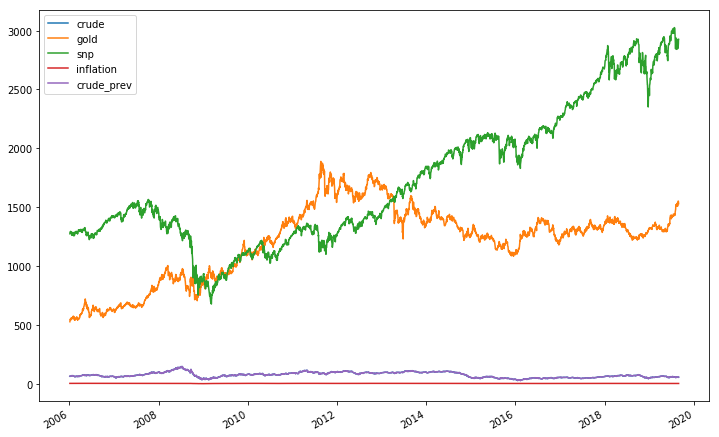

In [0]:
combined_data.plot(figsize=(12,8))

Calculating Relative Strenght Index

In [0]:
delta = combined_data['crude_prev'].diff()
delta = delta[1:]
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
down = down.abs()
    #calculating the moving averages
roll_up1 = up.ewm(span=14,adjust=False).mean()
roll_down1 = down.ewm(span=14,adjust=False).mean()
    #calculating RSI
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

#Adding it to the Data Base

combined_data['crude_rsi'] = RSI1

In [0]:
combined_data.dropna(inplace=True)

Function to determine, oversold, Overbought and Neutral indicator

In [0]:
def strength_determine(x):
    if x <= 20:
        strength = 'Heavily Oversold'
    elif x > 20 and x <=40:
        strength = 'Oversold'
    elif x > 40 and x <=60:
        strength = 'Neutral'
    elif x > 60 and x < 80:
        strength = 'Overbought'
    else:
        strength = 'Heavily Ovebought'
    
    return strength

In [0]:
combined_data['strength'] = combined_data['crude_rsi'].apply(strength_determine)

In [0]:
combined_data.head()

,crude,gold,snp,inflation,crude_prev,crude_rsi,strength
2006-01-06,64.21,539.7,1285.45,2.33,62.79,0.000000,Heavily Oversold
2006-01-09,63.50,549.1,1290.15,2.33,64.21,25.747960,Oversold
2006-01-10,63.37,544.3,1289.69,2.37,63.50,22.417876,Oversold
2006-01-11,63.94,548.8,1294.18,2.39,63.37,21.821621,Oversold
2006-01-12,63.94,548.3,1286.06,2.41,63.94,31.093682,Oversold


Caculating buym sell or hold singnal using moving averages

In [0]:
combined_data['short_window'] = combined_data['crude_prev'].ewm(span=25,adjust=False).mean()
combined_data['long_window'] = combined_data['crude_prev'].ewm(span=50,adjust=False).mean()

Creating the signal for the buy, sell or hold 

In [0]:
combined_data['signal'] = 0.0

combined_data['signal'] = np.where(combined_data['short_window']
                                            > combined_data['long_window'], 1.0, 0.0)

#Generating trade positions
combined_data['positions'] = combined_data['signal'].diff()

In [0]:
combined_data.head()

,crude,gold,snp,inflation,crude_prev,crude_rsi,strength,short_window,long_window,signal,positions
2006-01-06,64.21,539.7,1285.45,2.33,62.79,0.000000,Heavily Oversold,62.790000,62.790000,0.0,NaN
2006-01-09,63.50,549.1,1290.15,2.33,64.21,25.747960,Oversold,62.899231,62.845686,1.0,1.0
2006-01-10,63.37,544.3,1289.69,2.37,63.50,22.417876,Oversold,62.945444,62.871346,1.0,0.0
2006-01-11,63.94,548.8,1294.18,2.39,63.37,21.821621,Oversold,62.978102,62.890901,1.0,0.0
2006-01-12,63.94,548.3,1286.06,2.41,63.94,31.093682,Oversold,63.052094,62.932042,1.0,0.0


In [0]:
combined_data.dropna(inplace=True)

In [0]:
change = {1.0:'Buy', 0.0:'Hold', -1.0:'Sell'}
combined_data = combined_data.replace({'positions': change})

In [0]:
ann = combined_data

In [0]:
ann.drop(['crude_rsi','short_window','long_window', 'signal'], inplace=True, axis=1)

In [0]:
ann.head()

,crude,gold,snp,inflation,crude_prev,strength,positions
2006-01-09,63.50,549.1,1290.15,2.33,64.21,Oversold,Buy
2006-01-10,63.37,544.3,1289.69,2.37,63.50,Oversold,Hold
2006-01-11,63.94,548.8,1294.18,2.39,63.37,Oversold,Hold
2006-01-12,63.94,548.3,1286.06,2.41,63.94,Oversold,Hold
2006-01-13,63.92,556.1,1287.61,2.39,63.94,Oversold,Hold


In [0]:
ann = pd.get_dummies(ann,drop_first=True)

In [0]:
ann.head()

,crude,gold,snp,inflation,crude_prev,strength_Heavily Oversold,strength_Neutral,strength_Overbought,strength_Oversold,positions_Hold,positions_Sell
2006-01-09,63.50,549.1,1290.15,2.33,64.21,0,0,0,1,0,0
2006-01-10,63.37,544.3,1289.69,2.37,63.50,0,0,0,1,1,0
2006-01-11,63.94,548.8,1294.18,2.39,63.37,0,0,0,1,1,0
2006-01-12,63.94,548.3,1286.06,2.41,63.94,0,0,0,1,1,0
2006-01-13,63.92,556.1,1287.61,2.39,63.94,0,0,0,1,1,0


In [0]:
ann.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3408 entries, 2006-01-09 to 2019-08-30
Data columns (total 11 columns):
crude                        3408 non-null float64
gold                         3408 non-null float64
snp                          3408 non-null float64
inflation                    3408 non-null float64
crude_prev                   3408 non-null float64
strength_Heavily Oversold    3408 non-null uint8
strength_Neutral             3408 non-null uint8
strength_Overbought          3408 non-null uint8
strength_Oversold            3408 non-null uint8
positions_Hold               3408 non-null uint8
positions_Sell               3408 non-null uint8
dtypes: float64(5), uint8(6)
memory usage: 179.7 KB


# Plotting dustribution

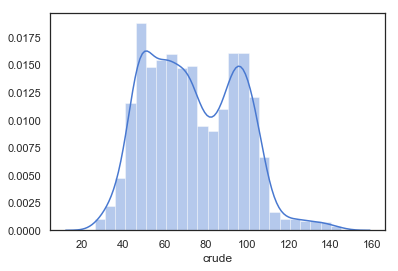

In [0]:
sns.distplot(ann['crude'])

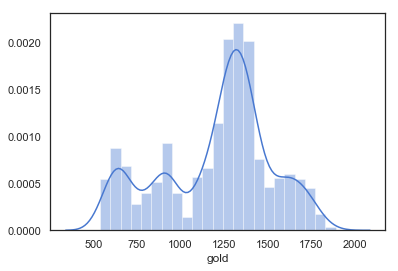

In [0]:
sns.distplot(ann['gold'])

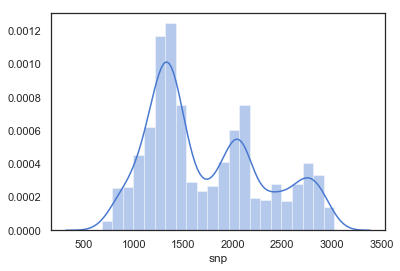

In [0]:
sns.distplot(ann['snp'])

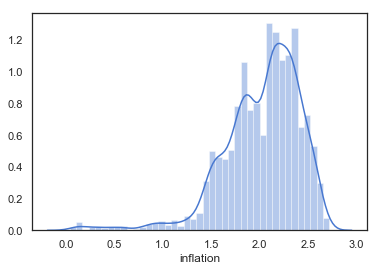

In [0]:
sns.distplot(ann['inflation'])

Text(0.5, 1.0, 'Crude and S&P500')

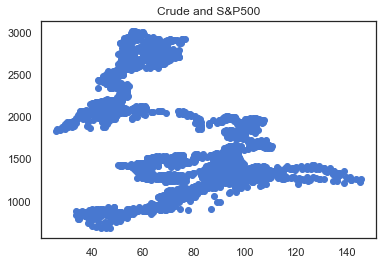

In [0]:
plt.scatter(ann['crude'],ann['snp'])
plt.title('Crude and S&P500')

Text(0.5, 1.0, 'Crude and Gold')

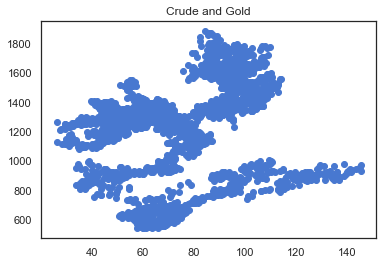

In [0]:
plt.scatter(ann['crude'],ann['gold'])
plt.title('Crude and Gold')

Text(0.5, 1.0, 'Crude and Infaltion')

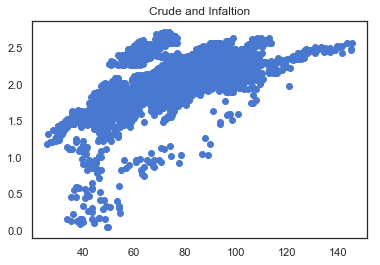

In [0]:
plt.scatter(ann['crude'],ann['inflation'])
plt.title('Crude and Infaltion')

Calculating Correlation matrix

In [0]:
Corr_matrix = ann[['crude', 'gold', 'snp', 'inflation', 'crude_prev']].corr()

In [0]:
Corr_matrix

,crude,gold,snp,inflation,crude_prev
crude,1.000000,0.236133,-0.392447,0.613675,0.997428
gold,0.236133,1.000000,0.294710,-0.013812,0.235641
snp,-0.392447,0.294710,1.000000,-0.125881,-0.392668
inflation,0.613675,-0.013812,-0.125881,1.000000,0.610454
crude_prev,0.997428,0.235641,-0.392668,0.610454,1.000000


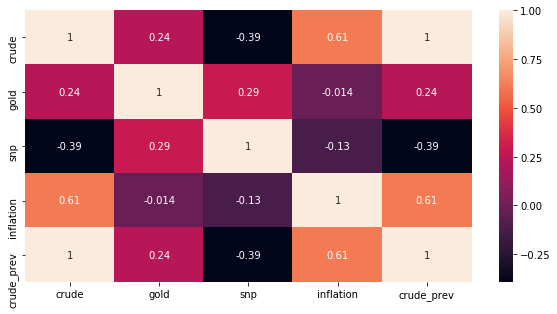

In [0]:
plt.figure(figsize=(10,5))
sns.heatmap(Corr_matrix, annot=True)

Splitting into dependent and independent variables

In [0]:
ann_X = ann.iloc[:,1:11].values
ann_y = ann.iloc[:, 0].values

Splitting into test and train datasets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(ann_X, ann_y, test_size=0.1, random_state=42)

Standardizing the data

In [0]:
sc = StandardScaler()

In [0]:
X_train = sc.fit_transform(X_train)

In [0]:
X_test = sc.transform(X_test)

Creating the model

In [0]:
regressor = Sequential()
regressor.add(Dense(output_dim = 6, init = 'uniform', activation = 'relu', input_dim=10))
#regressor.add(Dropout(0.5))
regressor.add(Dense(output_dim = 6, init = 'uniform', activation = 'relu'))
#regressor.add(Dense(output_dim = 4, init = 'uniform', activation = 'relu'))
#regressor.add(Dropout(0.5))
regressor.add(Dense(output_dim = 1, init = 'uniform'))

W1001 16:31:49.578690 10400 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1001 16:31:49.606646 10400 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1001 16:31:49.612599 10400 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Compile the model

In [0]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

W1001 16:31:55.785751 10400 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Fit the model

In [0]:
regressor.fit(X_train, y_train, epochs=100, batch_size=5, verbose=0)

W1001 16:32:05.165670 10400 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1001 16:32:05.373111 10400 deprecation_wrapper.py:119] From C:\Users\gudkumar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Model Summary

In [0]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________


## Predicting on the test set

In [0]:
y_pred = regressor.predict(X_test)

In [0]:
eval_ann = pd.DataFrame()
eval_ann['Actual'] = y_test
eval_ann['ANNPredction'] = y_pred

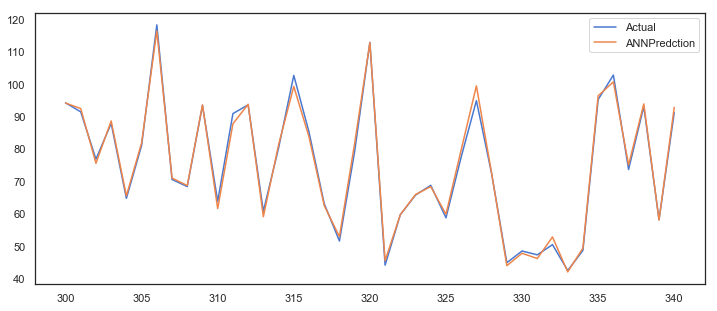

In [0]:
eval_ann.iloc[300:,].plot(figsize=(12,5))

In [0]:
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse_ann)

Test RMSE: 1.757
